<a href="https://colab.research.google.com/github/Wycology/deep_learning_course/blob/main/3_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'><b> SATELLITE DATA FOR AGRICULTURAL ECONOMISTS</b></font>


<font color='blue'><b>THEORY AND PRACTICE</b></font>

**_MACHINE & DEEP LEARNING_**


*David Wuepper, Hadi Hadi, Wyclife Agumba Oluoch*

[Land Economics Group](https://www.ilr1.uni-bonn.de/en/research/research-groups/land-economics), University of Bonn, Bonn, Germany

---

# **Background**
---
In this session, we are introducing the use of `PyTorch` in implementing deep learning task. Specifically we will introduce the use of `torchgeo`. According to the authors, `torchgeo` is a `PyTorch` domain library, similar to torchvision, providing **datasets**, **samplers**, **transforms**, and **pre-trained models** specific to **geospatial** data. We will use it to help work with **geospatial** nature of the data being fed into the `PyTorch` modeling framework.

We will commence this by installing `torchgeo`. Yes, `torchgeo` is not natively implemented in Google Colab, as opposed to `PyTorch`, so we need to install it.

### **What are we going to do here?**

We will:
1. Import the necessary libraries
2. Bring in sample data (which comes with `torchgeo`) to play with
3. Load the data (train, eval, test)
4. Build the model
5. Evaluate the model


In [ ]:
%pip install torchgeo # When asked to restart session, do so.

In [4]:
pip install azcopy

ERROR: Could not find a version that satisfies the requirement azcopy (from versions: none)
ERROR: No matching distribution found for azcopy


## **Import libraries**
In the next code section, we import all the necessary libraries.

In [39]:
import os # For connecting to file path
import tempfile # For putting downloaded data to temporary file

import random
import kornia.augmentation as K # For transforming dataset
import torch # For model building
from torch import nn, optim # Source of the network and optimization
from torch.utils.data import DataLoader, Subset # For loading data from directory

from torchgeo.datasets import EuroSAT100, EuroSAT # The dataset to work with
from torchgeo.models import ResNet18_Weights, resnet18 # The model weights and model itself

torch.manual_seed(248) # For reproducibility

## **Data**

Normally when talking about data in deep learning, we are referring to a combination of both inputs and outputs. Inputs can be like satellite images and outputs are like masks of classes of vegetation. This pair of input and output form dataset on which a model can learn. This dataset can be expressed mathematically as:

$D = \{(x^{(i)}, y^{(i)})\}_{i=1}^N$

This can be explained as dataset $D$ is composed of $N$ pairs of $x$ inputs and $y$ expected outputs. In our case, $x$ are the satellite images and $y$ are the labels for each image in $x$.

### **Visualize the dataset**

We can have a look at some of the images in the dataset. To do that, we will create a place in temporary directory to hold the data, download the data and load it into our session then visualize some random images.

In [9]:
path = os.path.join(tempfile.gettempdir(), 'eurosat') # Create temporary place to hold data
dataset = EuroSAT(path, download = True) # Download data and put in path

100%|██████████| 2.07G/2.07G [00:17<00:00, 118MB/s]


100%|██████████| 314k/314k [00:00<00:00, 4.20MB/s]


100%|██████████| 105k/105k [00:00<00:00, 6.13MB/s]


100%|██████████| 104k/104k [00:00<00:00, 5.62MB/s]


In [14]:
# Let us check the number of images we have
len(dataset) # 16200

16200

Now, we have our data downloaded. The data is made is such a way that both $x$ and $y$ are made available and have been split somehow into training, validation and testing sets. We can then have a simple loop through the data to view some of the images.

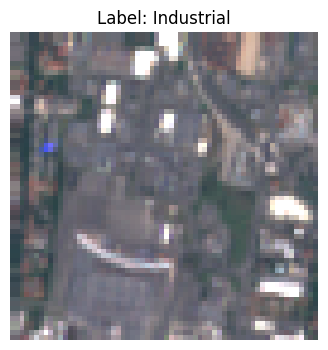

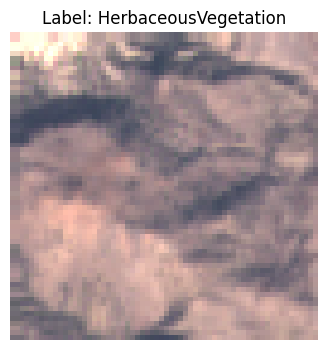

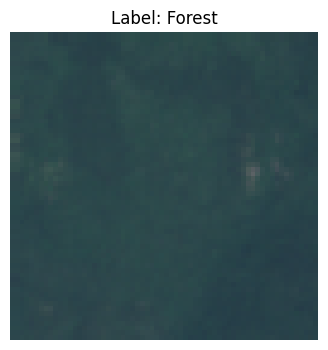

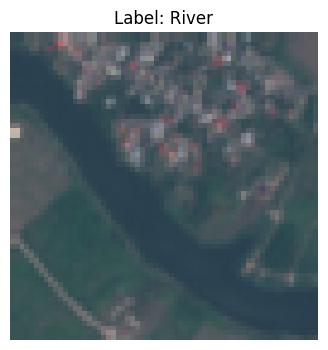

In [11]:
torch.manual_seed(248) # For reproducibility
for i in torch.randint(len(dataset), (4,)): # Pick 4 random samples
  sample = dataset[i]
  dataset.plot(sample) # Plot the images (Industrial, HerbaceusVegetation, Forest, and River)

## **Splitting the dataset**

Since we are convinced that we have our dataset, which is input output pair, we can now split it into:
* $train$ - for training the model parameters
* $val$ - for validating the model hyperparameters, and
* $test$ - for testing model performance

Lucky enough, we do not have to worry about the splitting because the data has been split apriori. You might have noticed this during downloading stage, the progress bars. We only need to indicate the $split$ argument in the `EuroSAT` function as follows:

In [12]:
train_dataset = EuroSAT(path, split = 'train')
val_dataset = EuroSAT(path, split = 'val')
test_dataset = EuroSAT(path, split = 'test')

In [19]:
# Confirm the number of images in each dataset.

print(f"The length of train dataset is: {len(train_dataset)}.")
print(f"The length of val dataset is: {len(val_dataset)}.")
print(f"The length of test dataset is: {len(test_dataset)}.")

The length of train dataset is: 16200.
The length of val dataset is: 5400.
The length of test dataset is: 5400.


This is quite a lot of data to train model on. I will therefore only take random 10% of each for this demo.

In [60]:
# Define the sample sizes (10% of each dataset)
train_size = 1620
val_size = 540
test_size = 540

# Create subsets by randomly sampling indices
train_indices = random.sample(range(len(train_dataset)), train_size)
val_indices = random.sample(range(len(val_dataset)), val_size)
test_indices = random.sample(range(len(test_dataset)), test_size)

# Create Subset datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

# Create DataLoaders for the subsets
train_dataloader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

In [76]:
len(train_subset) # Now we have small data we can train within a few minutes

1620

## **Data Laoding**
To train our model, validate and test, we need to load data from directory to it. Normally, we work with huge amount of data. Therefore, normally, we cannot load all the data into the RAM of our computer and train the model on it. Accordingly, we need a system which is capable of loading the data in mini-batches so that at every instance, only a few images are present in the RAM for training. To do this, we depend on **DataLoaders**. The only decision we have to make here is how many images we want to load in the RAM at a time, a value called $batch size$.

In [44]:
batch_size = 128 # Here I chose 128
# Run the three lines of code below if you want to train the model on full dataset.

# train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
# val_dataloader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=False)
# test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

At this point, it is important to verify that the data loaders are working as expected. That is, they are able to bring data from specified directory and avail them ready for model building. Let us start with _train_dataloader_.

In [61]:
for batch in train_dataloader:
  print(batch.keys()) # Confirm that both images and labels are paired.
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}") # We can see ([128, 13, 64, 64])
  print(f"Shape of the label is: {label.shape}") # We can see ([128])
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([128, 13, 64, 64])
Shape of the label is: torch.Size([128])


We notice that in each batch dictionary, there is **image** and **label** keys. Each batch has 128 images, each with 13 channels/bands, and 64 * 64 in height and width dimensions.
On the other hand, each batch has 128 labels corresponding to each of the 128 images. To expound on the labels, they are as follows:
* 0 == Annual crop
* 1 == Forest
* 2 == Herbaceous vegetation
* 3 == Highway
* 4 == Industrial building
* 5 == Pasture
* 6 == Permanent crop
* 7 == Residential building
* 8 == River
* 9 == Sea or Lake

Now we do the same for the _val_ and _test_ sets.

In [62]:
for batch in val_dataloader:
  print(batch.keys())
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}")
  print(f"Shape of the label is: {label.shape}")
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([128, 13, 64, 64])
Shape of the label is: torch.Size([128])


In [63]:
for batch in test_dataloader:
  print(batch.keys())
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}")
  print(f"Shape of the label is: {label.shape}")
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([128, 13, 64, 64])
Shape of the label is: torch.Size([128])


## **Transforming datasets**

From the raw data that is loaded in mini-batch by the dataloaders, one may need to do a number of transformations/augmentations. The transformations are nowmally divided into two:
1. Preprocessing - This is meant to make ML-ready data. For example, normalizing the values.
2. Augmentation - Meant to inflate the size of data, for example, rotation and flipping.

These can be implemented as follows:

In [64]:
means = []
stds = []

# Iterate over the DataLoader
for batch in train_dataloader:
    images = batch['image']  # Get images
    means.append(images.mean(dim=(0, 2, 3)))  # Mean across batch, height, and width
    stds.append(images.std(dim=(0, 2, 3)))  # Standard deviation across batch, height, and width

# Convert lists to tensors and compute the overall mean and std
mean_per_band = torch.stack(means).mean(dim=0)
std_per_band = torch.stack(stds).mean(dim=0)

print("Mean per band:", mean_per_band)
print("Standard deviation per band:", std_per_band)

KeyboardInterrupt: 

In [65]:
# The means and standard deviations below, I obtained from full dataset.
preprocess = K.Normalize(mean = [1354.4692, 1118.3010, 1042.9586,  947.6596, 1199.4612, 1999.7946, 2369.2322,
                                 2296.8015,  732.0518,   12.1152, 1818.9281, 1118.9769, 2594.1172],
                         std = [244.1971,  331.4640,  393.4827,  591.6816,  564.2270,  857.7773, 1082.3331,
                                1114.0242,  402.8415,    4.5873,  998.6683,  758.6846, 1226.5707])

On the other hand, for augmentation, we can have one or more in a sequence as follows:

In [66]:
augment = K.ImageSequential(K.RandomHorizontalFlip(),
                            K.RandomVerticalFlip())

## **Model Building**

Once we have appropriate data loaders bringing in data and the transformations acting on the loaded datasets, it is time to build the model. There exists a lot of pretrained models which we can work with. In this case, we will use `restnet18` and its associated weights relevant for sentinel2 dataset we are working with.

In [67]:
model = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO)

### **Calculating loss function**

In deep learning, the dataset is normally exposed to the model several times. Each time a model sees all data is called $epoch$. After the model has learnt through the data, we can determine how far away from actual labels, $y$, the predictions $\hat{y}$ are. This is normally achieved through a $loss$ $function$. The purpose of loss function is to aim at reducing the difference between actual labels and predicted labels after every training run, $epoch$.

In [68]:
loss_fn = nn.CrossEntropyLoss()

## **Optimizers**

After calculating the loss, difference between observed and predicted output, minimizing the loss involves taking a small step, $learning$ $rate$, in the direction of negative gradient ($backpropagation$). This is done one image or mini-batch at a time; stochastic gradient descent (SGD) as follows.

In [69]:
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

## **Moving data and model to device**

Normally, the linear algebraic calculations involved in deep learning are better handled on the GPU. So, both data and model need to be transferred from CPU to GPU to enable efficient training. This can be achieved by:

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

We can check what our device is here:

In [71]:
device # Returns 'cpu' because we did not yet set it to GPU in the runtime.

'cpu'

## **Training the model**

This involves setting the model to train mode then iterating over the mini-batches in the dataset. During the forward pass, we ask the model to predict y given x. During backward pass, we do backpropagation in which we update model weights. This can be achieved as follows:

In [72]:
def train(dataloader):
  model.train()
  total_loss = 0
  for batch in dataloader:
    x = batch['image'].to(device)
    y = batch['label'].to(device)

    # Forward pass
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    total_loss += loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print(f"Loss: {total_loss:.2%}")

## **Evaluating the model**

After training a model, we should evaluate it on unseen data to see how it performs. This involves setting the model to evaluation mode then iterating through the minibatches. We do not engage backpropagation here but compute the number of correctly classified images.

In [73]:
def evaluate(dataloader):
  model.eval()
  correct = 0.0
  with torch.no_grad():
    for batch in dataloader:
      x = batch['image'].to(device)
      y = batch['label'].to(device)

      # Forward pass
      y_hat = model(x)
      correct += (y_hat.argmax(1) == y).float().sum().item()

  correct /= len(dataloader.dataset)
  print(f"Accuracy: {correct:.0%}")

## **Running for x epochs**

Now we need to run this several times so that our model can learn and improve over time. Say, we want to run it 20 times. This means we set epochs to 20 as follows:

In [74]:
epochs = 20

Normally, we would set such number of epochs that ensures that we see reduction in loss and increase in accuracy. Better still, we want to train the model until the validation accuracy starts to plateau or even decrease. At that point the model shall have sufficiently learnt.

In [75]:
for epoch in range(epochs):
  print(f"Epoch: {epoch}")
  train(train_dataloader)
  evaluate(val_dataloader)

Epoch: 0
Loss: 8944.77%
Accuracy: 1%
Epoch: 1
Loss: 8870.59%
Accuracy: 15%
Epoch: 2
Loss: 8786.26%
Accuracy: 28%
Epoch: 3
Loss: 8677.12%
Accuracy: 43%
Epoch: 4
Loss: 8553.00%
Accuracy: 56%
Epoch: 5
Loss: 8398.52%
Accuracy: 63%
Epoch: 6
Loss: 8198.41%
Accuracy: 65%
Epoch: 7
Loss: 7973.97%
Accuracy: 67%
Epoch: 8
Loss: 7734.79%
Accuracy: 70%
Epoch: 9
Loss: 7497.45%
Accuracy: 71%
Epoch: 10
Loss: 7282.25%
Accuracy: 71%
Epoch: 11
Loss: 7063.66%
Accuracy: 71%
Epoch: 12
Loss: 6844.79%
Accuracy: 72%
Epoch: 13
Loss: 6612.44%
Accuracy: 72%
Epoch: 14
Loss: 6378.79%
Accuracy: 72%
Epoch: 15
Loss: 6090.93%
Accuracy: 73%
Epoch: 16
Loss: 5811.94%
Accuracy: 72%
Epoch: 17
Loss: 5521.81%
Accuracy: 73%
Epoch: 18
Loss: 5187.82%
Accuracy: 74%
Epoch: 19
Loss: 4810.84%
Accuracy: 75%


These are of course horrible performance, however, suited for this simple introductory workflow.

In [78]:
evaluate(test_dataloader)

Accuracy: 72%


## **References**
[PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)

[Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

[Transfer learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

# **Miscellaneous Using U-Net**

In [ ]:
%pip install torchseg
import torchseg
from tqdm import tqdm

In [87]:
model2 = torchseg.Unet(
    encoder_name = "resnet18",
    encoder_weights = False,
    in_channels = 13,
    classes = 10
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

In [89]:
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [90]:
# Training loop
metrics = {"loss": [], "accuracy": []}
num_epochs = 50

In [96]:
for epoch in range(num_epochs):
  model2.train()
  epoch_loss = 0.0
  total_correct = 0
  total_pixels = 0

  with tqdm(train_dataloader, desc = f"Epoch {epoch + 1} / {num_epochs}") as pbar:
    for batch in pbar:
      images = batch["image"][:, :13, :, :].to(device)
      masks = batch["label"].to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, masks.long())
      epoch_loss += loss.item()

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate accuracy
      preds = torch.argmax(outputs, dim = 1)
      total_correct += (preds == masks).sum().item()
      total_pixels += masks.numel()

      pbar.set_postfix(loss = loss.item())

  epoch_accuracy = total_correct / total_pixels * 100
  metrics["loss"].append(epoch_loss)
  metrics["accuracy"].append(epoch_accuracy)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

  # Save training metrics
  #with open("/content/training_metrics.json", "w") as f:
  #  json.dump(metrics, f)

  print("Training metrics saved to '/content/training_metrics.json")

Epoch 1 / 50: 100%|██████████| 13/13 [01:07<00:00,  5.20s/it, loss=3.56]


Epoch [1/50], Loss: 445.1351, Accuracy: 17.16%
Training metrics saved to '/content/training_metrics.json


Epoch 2 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.54s/it, loss=2.33]


Epoch [2/50], Loss: 32.8129, Accuracy: 9.75%
Training metrics saved to '/content/training_metrics.json


Epoch 3 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.56s/it, loss=2.31]


Epoch [3/50], Loss: 30.4854, Accuracy: 13.95%
Training metrics saved to '/content/training_metrics.json


Epoch 4 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.53s/it, loss=1.9]


Epoch [4/50], Loss: 27.6789, Accuracy: 21.23%
Training metrics saved to '/content/training_metrics.json


Epoch 5 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.55s/it, loss=1.88]


Epoch [5/50], Loss: 24.3523, Accuracy: 30.12%
Training metrics saved to '/content/training_metrics.json


Epoch 6 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.60s/it, loss=2.02]


Epoch [6/50], Loss: 25.3460, Accuracy: 26.91%
Training metrics saved to '/content/training_metrics.json


Epoch 7 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.49s/it, loss=1.6]


Epoch [7/50], Loss: 23.3344, Accuracy: 34.14%
Training metrics saved to '/content/training_metrics.json


Epoch 8 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it, loss=1.91]


Epoch [8/50], Loss: 21.9693, Accuracy: 38.83%
Training metrics saved to '/content/training_metrics.json


Epoch 9 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.56s/it, loss=1.52]


Epoch [9/50], Loss: 20.9061, Accuracy: 40.19%
Training metrics saved to '/content/training_metrics.json


Epoch 10 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it, loss=1.45]


Epoch [10/50], Loss: 19.4004, Accuracy: 44.26%
Training metrics saved to '/content/training_metrics.json


Epoch 11 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.54s/it, loss=1.42]


Epoch [11/50], Loss: 17.6674, Accuracy: 49.94%
Training metrics saved to '/content/training_metrics.json


Epoch 12 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.45s/it, loss=1.16]


Epoch [12/50], Loss: 16.2644, Accuracy: 53.77%
Training metrics saved to '/content/training_metrics.json


Epoch 13 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it, loss=1.21]


Epoch [13/50], Loss: 15.0645, Accuracy: 54.01%
Training metrics saved to '/content/training_metrics.json


Epoch 14 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it, loss=1.04]


Epoch [14/50], Loss: 14.6998, Accuracy: 55.06%
Training metrics saved to '/content/training_metrics.json


Epoch 15 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it, loss=1.09]


Epoch [15/50], Loss: 14.8493, Accuracy: 56.36%
Training metrics saved to '/content/training_metrics.json


Epoch 16 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.46s/it, loss=1.15]


Epoch [16/50], Loss: 13.8874, Accuracy: 58.33%
Training metrics saved to '/content/training_metrics.json


Epoch 17 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.52s/it, loss=0.937]


Epoch [17/50], Loss: 12.8995, Accuracy: 61.36%
Training metrics saved to '/content/training_metrics.json


Epoch 18 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.46s/it, loss=0.836]


Epoch [18/50], Loss: 12.5587, Accuracy: 61.60%
Training metrics saved to '/content/training_metrics.json


Epoch 19 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it, loss=1.07]


Epoch [19/50], Loss: 13.3060, Accuracy: 60.25%
Training metrics saved to '/content/training_metrics.json


Epoch 20 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it, loss=1.13]


Epoch [20/50], Loss: 12.7898, Accuracy: 62.72%
Training metrics saved to '/content/training_metrics.json


Epoch 21 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.45s/it, loss=0.981]


Epoch [21/50], Loss: 12.7088, Accuracy: 62.04%
Training metrics saved to '/content/training_metrics.json


Epoch 22 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.54s/it, loss=0.934]


Epoch [22/50], Loss: 11.4176, Accuracy: 65.80%
Training metrics saved to '/content/training_metrics.json


Epoch 23 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.48s/it, loss=0.861]


Epoch [23/50], Loss: 11.0255, Accuracy: 66.85%
Training metrics saved to '/content/training_metrics.json


Epoch 24 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.56s/it, loss=0.864]


Epoch [24/50], Loss: 10.3619, Accuracy: 68.40%
Training metrics saved to '/content/training_metrics.json


Epoch 25 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.54s/it, loss=0.752]


Epoch [25/50], Loss: 10.0712, Accuracy: 68.64%
Training metrics saved to '/content/training_metrics.json


Epoch 26 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.50s/it, loss=1.08]


Epoch [26/50], Loss: 10.2132, Accuracy: 68.95%
Training metrics saved to '/content/training_metrics.json


Epoch 27 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it, loss=1.27]


Epoch [27/50], Loss: 10.1315, Accuracy: 70.19%
Training metrics saved to '/content/training_metrics.json


Epoch 28 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.47s/it, loss=0.771]


Epoch [28/50], Loss: 11.6881, Accuracy: 65.31%
Training metrics saved to '/content/training_metrics.json


Epoch 29 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it, loss=0.743]


Epoch [29/50], Loss: 10.2243, Accuracy: 70.31%
Training metrics saved to '/content/training_metrics.json


Epoch 30 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it, loss=0.813]


Epoch [30/50], Loss: 9.9122, Accuracy: 70.43%
Training metrics saved to '/content/training_metrics.json


Epoch 31 / 50: 100%|██████████| 13/13 [00:57<00:00,  4.45s/it, loss=0.765]


Epoch [31/50], Loss: 9.7360, Accuracy: 71.11%
Training metrics saved to '/content/training_metrics.json


Epoch 32 / 50: 100%|██████████| 13/13 [01:01<00:00,  4.69s/it, loss=0.639]


Epoch [32/50], Loss: 9.0839, Accuracy: 72.84%
Training metrics saved to '/content/training_metrics.json


Epoch 33 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.55s/it, loss=0.676]


Epoch [33/50], Loss: 8.2971, Accuracy: 75.43%
Training metrics saved to '/content/training_metrics.json


Epoch 34 / 50: 100%|██████████| 13/13 [01:00<00:00,  4.64s/it, loss=0.55]


Epoch [34/50], Loss: 8.4035, Accuracy: 75.56%
Training metrics saved to '/content/training_metrics.json


Epoch 35 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.54s/it, loss=0.501]


Epoch [35/50], Loss: 8.4701, Accuracy: 75.31%
Training metrics saved to '/content/training_metrics.json


Epoch 36 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.50s/it, loss=0.711]


Epoch [36/50], Loss: 7.6637, Accuracy: 78.21%
Training metrics saved to '/content/training_metrics.json


Epoch 37 / 50: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it, loss=0.5]


Epoch [37/50], Loss: 6.9443, Accuracy: 79.94%
Training metrics saved to '/content/training_metrics.json


Epoch 38 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.56s/it, loss=0.563]


Epoch [38/50], Loss: 8.8765, Accuracy: 74.07%
Training metrics saved to '/content/training_metrics.json


Epoch 39 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it, loss=0.484]


Epoch [39/50], Loss: 7.8533, Accuracy: 77.78%
Training metrics saved to '/content/training_metrics.json


Epoch 40 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.59s/it, loss=0.521]


Epoch [40/50], Loss: 7.6027, Accuracy: 76.79%
Training metrics saved to '/content/training_metrics.json


Epoch 41 / 50: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it, loss=0.77]


Epoch [41/50], Loss: 7.8518, Accuracy: 77.84%
Training metrics saved to '/content/training_metrics.json


Epoch 42 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.55s/it, loss=0.612]


Epoch [42/50], Loss: 7.1289, Accuracy: 80.31%
Training metrics saved to '/content/training_metrics.json


Epoch 43 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.58s/it, loss=0.47]


Epoch [43/50], Loss: 7.0664, Accuracy: 81.17%
Training metrics saved to '/content/training_metrics.json


Epoch 44 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.53s/it, loss=0.466]


Epoch [44/50], Loss: 6.8072, Accuracy: 81.36%
Training metrics saved to '/content/training_metrics.json


Epoch 45 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it, loss=0.399]


Epoch [45/50], Loss: 6.3024, Accuracy: 81.98%
Training metrics saved to '/content/training_metrics.json


Epoch 46 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.58s/it, loss=0.501]


Epoch [46/50], Loss: 5.8522, Accuracy: 84.75%
Training metrics saved to '/content/training_metrics.json


Epoch 47 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it, loss=0.488]


Epoch [47/50], Loss: 5.9436, Accuracy: 83.89%
Training metrics saved to '/content/training_metrics.json


Epoch 48 / 50: 100%|██████████| 13/13 [00:59<00:00,  4.55s/it, loss=0.546]


Epoch [48/50], Loss: 6.1815, Accuracy: 82.65%
Training metrics saved to '/content/training_metrics.json


Epoch 49 / 50: 100%|██████████| 13/13 [00:58<00:00,  4.48s/it, loss=0.302]


Epoch [49/50], Loss: 5.2246, Accuracy: 86.05%
Training metrics saved to '/content/training_metrics.json


Epoch 50 / 50: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it, loss=0.316]

Epoch [50/50], Loss: 5.2012, Accuracy: 85.49%
Training metrics saved to '/content/training_metrics.json
